## Package and functions

In [432]:
import pandas as pd
from pathlib import Path
path = Path('/mnt/research-live/equity/reference/equity_data/sa_research/current/')
import pandas as pd 
import numpy as np 
import re

In [433]:
def ts_scale(v, halflife=252, min_periods=126, periods=None, use_std=True, ignore_na=False, nb_bins=1):
    """
    ts_scale:
        nb_bins (int): Number of bins, to scale the halflife to nb of days.
            Default is one for our daily program, but allows to accomodate for short term programs.
    """
    halflife *= nb_bins
    min_periods *= nb_bins
    if periods is not None: 
        periods *= nb_bins

    if periods is not None:
        v_ = v.pipe(nnan_shift, periods)
    else: 
        v_ = v
    if use_std: 
        std = v_.ewm(halflife=halflife, min_periods=min_periods, ignore_na=ignore_na).std()
    else: 
        std = v_.abs().ewm(halflife=halflife, min_periods=min_periods, ignore_na=ignore_na).mean()
    return v.div(std)

def ts_demean(v, halflife=252, ignore_na=False, min_periods=0, nb_bins=1):
    halflife *= nb_bins
    min_periods *= nb_bins
    return v.sub(v.ewm(halflife, ignore_na=ignore_na, min_periods=min_periods).mean())

In [436]:
def ts_zscore(v, halflife=252, ignore_na=False, min_periods=126, nb_bins=1, last_year_weight=False, last_year_news_weight=False):
    """
    Calculate the z-score of a time series with different weightage options.
    
    Inputs:
    - v: Time series data.
    - halflife: Halflife parameter for exponential weighting.
    - ignore_na: Flag to ignore NaN values 
    - min_periods: Minimum number of observations required for exponential weighting .
    - nb_bins: Number of bins to scale the halflife .
    - last_year_weight: Flag to apply weightage based on the number of days with news in the last year (default: False).
    - last_year_news_weight: Flag to apply weightage based on the average number of news in the last year (default: False).
    
    Outputs:
    - Z-scored time series.
    """
    if last_year_weight:
        last_year = v.index.year[-1]
        if last_year == 2008:
            n_days = (v[v.index.year == last_year] != 0).sum()
        else:
            n_days = (v[v.index.year == last_year - 1] != 0).sum()
        weight = np.sqrt(n_days)
        scaled = ts_scale(v, halflife=halflife, ignore_na=ignore_na, min_periods=min_periods, nb_bins=nb_bins)
        return scaled * weight
    elif last_year_news_weight:
        last_year = v.index.year[-1]
        if last_year == 2008:
            n_news = (v[v.index.year == last_year]).mean()
        else:
            n_news = (v[v.index.year == last_year - 1]).mean()
        weight = np.sqrt(n_news)
        scaled = ts_scale(v, halflife=halflife, ignore_na=ignore_na, min_periods=min_periods, nb_bins=nb_bins)
        return scaled * weight
    else:
        return ts_scale(ts_demean(v, halflife=halflife, ignore_na=ignore_na, min_periods=min_periods, nb_bins=nb_bins), halflife=halflife, ignore_na=ignore_na, min_periods=min_periods, nb_bins=nb_bins)


In [450]:
def plot_volume(eqt_code,news_volume_):
    news_volume_.query(f'eqt_code == {eqt_code}').set_index('event_date')['total_count'].sort_index().plot()
def plot_z_score(eqt_code,z_score_matrix):
    z_score_matrix[eqt_code].plot()

## Data Loading

In [466]:
df=pd.read_parquet('/mnt/research-live/user/yzhong/Single_level_stock/Single_stock_news_2023.parquet')

In [471]:
df=df[(df.eqt_code=='SIVB_UQ')&(df.date==pd.to_datetime('2023-03-10'))]

In [472]:
with open('/mnt/research-live/user/yzhong/top_volume_contents.txt', 'w') as f:
    for row in df.itertuples():
        f.write(f'{str(row.headline)}' + '\n')

In [191]:
from pathlib import Path
path = Path('/mnt/research-live/equity/reference/equity_data/sa_research/current/')
ead_ = pd.read_parquet(path /'CFM_AMER/equity_data/eqt_earning_announcement_dates.parquet') # date for earnings
news_volume__ =pd.read_parquet(path /'CFM_AMER/equity_data/eqt_bb_news_volumes.parquet') # volume for each date
eqt=pd.read_parquet('/mnt/research-live/equity/reference/equity_data/sa_research/current/CFM_AMER/equity_data/eqt_referential.parquet') #name of company

Filtering the earning days from the dataset

In [205]:
news_volume__['id']=news_volume__.index
filtered_df = news_volume__.merge(ead_, left_on=['eqt_code', 'event_date'], right_on=['eqt_code', 'earning_date'], how='inner')
news_volume_ = news_volume__[~news_volume__['id'].isin(filtered_df['id'])][['event_date', 'eqt_code', 'total_count']]

In [442]:
'''
creating a new DataFrame `news_volume_pivot` 
with `total_count` as values,
`event_date` as the index, 
`eqt_code` as columns, 
and filling missing values with `np.nan`.
'''
news_volume_pivot = news_volume_.pivot_table(values='total_count', index='event_date', columns='eqt_code', fill_value=np.nan)

## Vanilla Method: No Weighting or Data Filling

In [439]:
z_score_matrix = news_volume_pivot.apply(lambda x: ts_zscore(x, halflife=252, ignore_na=True, min_periods=126, nb_bins=1), axis=0)

<AxesSubplot:xlabel='event_date'>

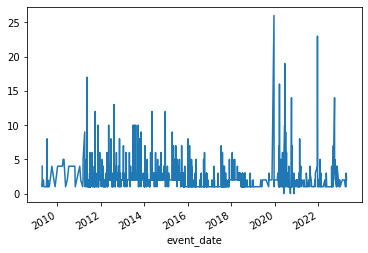

In [460]:
news_volume_.query(f'eqt_code == "CGX_U_CT"').set_index('event_date')['total_count'].sort_index().plot()

### Results for the top 50 z-score

In [440]:
top_50=z_score_matrix.stack().sort_values(ascending=False).head(50).reset_index()
top_50

,event_date,eqt_code,0
0,2023-03-10,SIVB_UQ,18.425088
1,2018-01-30,TOC_CN,17.488349
2,2018-01-30,TRI1_UN,17.463764
3,2020-09-29,NTT_UN,17.171782
4,2014-09-26,SV_UN,17.005758
5,2016-07-18,ARMH_UW,16.978181
6,2014-08-25,THI_UN,16.717772
7,2014-08-25,THI_CT,16.687271
8,2016-02-09,FTS_CT,16.667919
9,2021-01-13,ATD_B_CT,16.629087


In [441]:
merged_df = top_50.merge(news_volume__[["event_date", "eqt_code", "total_count"]], on=["event_date", "eqt_code"], how="left")
total_count_column = merged_df["total_count"]
merged_df.sort_values(by='total_count', ascending=False)

,event_date,eqt_code,0,total_count
0,2023-03-10,SIVB_UQ,18.425088,580
13,2021-01-28,GME_UN,16.464202,406
40,2014-04-28,AZN_UN,15.611830,353
37,2021-04-13,JNJ_UN,15.684081,322
49,2023-03-19,UBS_UN,15.515873,294
5,2016-07-18,ARMH_UW,16.978181,254
41,2016-06-13,LNKD_US,15.609728,254
34,2012-07-23,NXY_UN,15.757460,215
19,2012-07-23,NXY_CN,16.090855,215
24,2013-02-14,HNZ_UN,15.940132,207


### Problems encountered

This method may introduce bias, as the NaN values can impact the z-score, potentially underestimating the significance of sudden news appearances.

## Method 1: fill the news volume with 0 from the first day that one company has news

In [207]:
'''
Filling the news_volume_pivot table with 0
when it first encounter a non null value
'''
for column in news_volume_pivot:
    mask = news_volume_pivot[column].notnull()
    if mask.any():
        first_valid_index = mask.idxmax()
        news_volume_pivot.loc[first_valid_index:, column].fillna(0, inplace=True)

In [390]:
z_score_matrix = news_volume_pivot.apply(lambda x: ts_zscore(x, halflife=252, ignore_na=True, min_periods=126, nb_bins=1), axis=0)

### Results for the top 50 z-score

In [391]:
top_50=z_score_matrix.stack().sort_values(ascending=False).head(50).reset_index()

In [392]:
merged_df = top_50.merge(news_volume__[["event_date", "eqt_code", "total_count"]], on=["event_date", "eqt_code"], how="left")
total_count_column = merged_df["total_count"]
merged_df.sort_values(by='total_count', ascending=False)

,event_date,eqt_code,0,total_count
10,2014-06-02,AEGR_US,18.726956,1163
2,2014-06-02,BEBE_UQ,19.034207,1156
16,2014-06-02,FLDM_US,18.596970,1043
17,2014-06-02,PAMT_US,18.584369,1037
12,2014-06-02,ZGNX_US,18.667584,832
5,2014-06-02,SGYP_UV,18.972696,727
1,2014-06-02,PDII1_UQ,19.037595,725
3,2014-06-02,SGMO1_UQ,19.019451,723
4,2014-06-02,RBCN_US,19.015763,721
11,2023-03-10,SIVB_UQ,18.713169,580


### Problems encountered

From the given example, it is evident that when an enterprise does not have any news updates between the dates 2012-01-17 and 2015-11-19, the calculated z-score for the date 2015-11-19 may be biased or misleading.

In [393]:
news_volume__[(news_volume__.eqt_code=='CUK_UN')]

,event_date,utilisation_date_local,eqt_daprice_local,cfm_date_type,cfm_adjust_date,cfm_insert_date,utilisation_date,daclose,eqt_code,total_count,...,count_pos_mret,count_neg_mret,count_pos_roberta_headline,count_neg_roberta_headline,total_readership,readership_pos_sent,readership_neg_sent,readership_pos_mret,readership_neg_mret,id
813275,2012-01-17,2012-01-18,2012-01-17,HIST,2012-01-18 03:30:00,2012-01-18 03:30:00,2012-01-18,2012-01-17,CUK_UN,1,...,0,1,0,1,0,0,0,0,0,813275
2293680,2015-11-19,2015-11-20,2015-11-19,HIST,2015-11-20 03:30:00,2015-11-20 03:30:00,2015-11-20,2015-11-19,CUK_UN,2,...,0,0,0,0,125,0,0,125,0,2293680
2298406,2015-11-24,2015-11-25,2015-11-24,HIST,2015-11-25 03:30:00,2015-11-25 03:30:00,2015-11-25,2015-11-24,CUK_UN,1,...,0,1,0,1,0,0,0,0,0,2298406
2339529,2016-01-06,2016-01-07,2016-01-06,HIST,2016-01-07 03:30:00,2016-01-07 03:30:00,2016-01-07,2016-01-06,CUK_UN,2,...,1,0,0,0,25,0,0,25,0,2339529
2349578,2016-01-14,2016-01-15,2016-01-14,HIST,2016-01-15 03:30:00,2016-01-15 03:30:00,2016-01-15,2016-01-14,CUK_UN,3,...,0,1,1,0,75,0,0,0,75,2349578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4163253,2023-03-16,2023-03-17,2023-03-16,PIT,2023-03-17 03:30:00,2023-03-17 03:30:00,2023-03-17,2023-03-16,CUK_UN,1,...,0,1,1,0,25,0,0,0,25,4163253
4167189,2023-03-27,2023-03-28,2023-03-27,PIT,2023-03-28 03:30:00,2023-03-28 03:30:00,2023-03-28,2023-03-27,CUK_UN,10,...,0,10,5,4,50,0,25,0,50,4167189
4173208,2023-04-11,2023-04-12,2023-04-11,PIT,2023-04-12 03:30:00,2023-04-12 03:30:00,2023-04-12,2023-04-11,CUK_UN,1,...,0,0,0,0,0,0,0,0,0,4173208
4174844,2023-04-14,2023-04-17,2023-04-14,PIT,2023-04-15 03:30:00,2023-04-15 03:30:00,2023-04-17,2023-04-14,CUK_UN,1,...,0,0,0,0,0,0,0,0,0,4174844


## Method2: Weighting the z-score

### A.  Based on the number of days within the last year that a company has news updates.

In [348]:
z_score_matrix = news_volume_pivot.apply(lambda x: ts_zscore(x, halflife=252, ignore_na=True, min_periods=126, nb_bins=1, last_year_weight=True), axis=0)

In [363]:
top_50=z_score_matrix.stack().sort_values(ascending=False).head(50).reset_index()

**Example of the news:**

Twitter:

- On April 13, 2022, Elon Musk announced the acquisition of Twitter.
- On September 5, 2018, Twitter faced controversy over supposed account shadow banning. The company claimed it was a bug that resulted in the unfair filtering of 600,000 accounts.


In [365]:
top_100[top_100['eqt_code']=='TWTR_US']

,event_date,eqt_code,0
28,2022-04-14,TWTR_US,237.201116
83,2018-09-05,TWTR_US,212.235767


In [335]:
merged_df = top_50.merge(news_volume__[["event_date", "eqt_code", "total_count"]], on=["event_date", "eqt_code"], how="left")
total_count_column = merged_df["total_count"]
merged_df.sort_values(by='total_count', ascending=False)

,event_date,eqt_code,0,total_count
5,2023-03-10,SIVB_UQ,257.898156,580
31,2019-03-12,BA_UN,236.254473,520
48,2013-01-16,BA_UN,229.065699,480
14,2023-03-20,UBS_UN,246.466352,455
2,2019-03-11,BA_UN,273.526984,433
32,2013-09-03,MSFT_UQ,236.115772,431
41,2021-01-28,GME_UN,231.776948,406
22,2023-03-15,CS2_UN,240.144727,378
4,2011-08-08,BVMF3_BS,260.553537,368
1,2014-04-28,AZN_UN,277.978669,353


### B.  Based on the number of news within the last year that a company has updated.

In [367]:
z_score_matrix = news_volume_pivot.apply(lambda x: ts_zscore(x, halflife=252, ignore_na=True, min_periods=126, nb_bins=1, last_year_weight=False, last_year_news_weight=True), axis=0)

In [368]:
top_50=z_score_matrix.stack().sort_values(ascending=False).head(50).reset_index()
top_50

,event_date,eqt_code,0
0,2012-09-25,TSLA_UW,66.099328
1,2022-04-14,TWTR_US,61.320663
2,2011-08-25,AAPL_UQ,59.046817
3,2014-09-09,AAPL_UQ,55.756211
4,2018-09-05,TWTR_US,54.866681
...,...,...,...
195,2022-03-01,RDS_A_UN,30.934068
196,2021-02-22,PBR_A_US,30.876624
197,2022-02-22,HBC_UN,30.865102
198,2018-03-19,FB_US,30.865087


In [340]:
merged_df = top_50.merge(news_volume__[["event_date", "eqt_code", "total_count"]], on=["event_date", "eqt_code"], how="left")
total_count_column = merged_df["total_count"]
merged_df.sort_values(by='total_count', ascending=False)

,event_date,eqt_code,0,total_count
43,2010-04-27,GS_UN,42.039304,624
22,2010-04-19,GS_UN,45.671074,557
31,2019-03-12,BA_UN,43.430364,520
3,2014-09-09,AAPL_UQ,55.756211,508
5,2011-10-06,AAPL_UQ,54.514649,490
41,2013-01-16,BA_UN,42.108861,480
34,2023-03-16,CS2_UN,42.793974,444
2,2011-08-25,AAPL_UQ,59.046817,439
10,2019-03-11,BA_UN,50.282123,433
6,2013-09-03,MSFT_UQ,53.047718,431


## Method3: Filtering certain stocks based on condition

In [465]:
print(f'number of all eqt_code: {len(news_volume_pivot.columns.to_list())}')

number of all eqt_code: 4025


In [414]:
unique_years = news_volume_pivot.index.year.unique()  # Get unique year indices
columns_to_drop = []

for column in news_volume_pivot.columns:
    for year in unique_years:
        values = news_volume_pivot[column][news_volume_pivot.index.year == year]
        if (values == 0).all():
            columns_to_drop.append(column)
            break
        else:
            continue

In [464]:
print(f'number of dropped eqt_code: {len(columns_to_drop)}')

number of dropped eqt_code: 1375


In [417]:
news_volume_pivot_dropped = news_volume_pivot.drop(columns_to_drop, axis=1)

In [419]:
z_score_matrix = news_volume_pivot_dropped.apply(lambda x: ts_zscore(x, halflife=252, ignore_na=True, min_periods=126, nb_bins=1), axis=0)

In [421]:
top_50=z_score_matrix.stack().sort_values(ascending=False).head(50).reset_index()
top_50

,event_date,eqt_code,0
0,2014-06-02,SGMO1_UQ,19.019451
1,2014-04-15,ZBRA_UQ,18.727672
2,2023-03-13,SBNY_UQ,18.727012
3,2023-03-10,SIVB_UQ,18.713169
4,2017-07-03,WFSL_UQ,18.666126
5,2017-07-03,WABC_UQ,18.599840
6,2014-06-02,FLDM_US,18.596970
7,2014-06-02,PAMT_US,18.584369
8,2017-07-03,CFFN_UQ,18.542671
9,2017-07-03,CLFD_US,18.516784


In [428]:
eqt.loc['PH_UN', 'cmp_name']

'Parker-Hannifin Corp'

In [423]:
merged_df = top_50.merge(news_volume__[["event_date", "eqt_code", "total_count"]], on=["event_date", "eqt_code"], how="left")
total_count_column = merged_df["total_count"]
merged_df.sort_values(by='total_count', ascending=False)

,event_date,eqt_code,0,total_count
34,2014-06-02,CLVS_US,18.014976,1252
6,2014-06-02,FLDM_US,18.596970,1043
7,2014-06-02,PAMT_US,18.584369,1037
0,2014-06-02,SGMO1_UQ,19.019451,723
3,2023-03-10,SIVB_UQ,18.713169,580
44,2016-12-08,NAVIV_US,17.897414,244
2,2023-03-13,SBNY_UQ,18.727012,164
40,2020-09-29,NTT_UN,17.944378,163
47,2012-11-12,LUK_UN,17.867652,132
12,2013-12-16,AER_UN,18.395762,128


## Comments